# Example 2 - Custom Template

Example 1 showed how a pre-defined recipe could be used to build up a model - in this case around semi-lumped catchments generating runoff and constituent loads.

This example looks at how a new recipe might be built, starting with a template for a repeatable model unit.

Where the SemiLumpedCatchment allowed some configuration by the user (in terms of constituents, HRUs, CGUs), here we will lock down the configuration as you might do when building a bespoke solution.

Here, we will look at a model that estimates hillslope fine sediment. The template might be applied at different spatial scales, ranging from grid cell to subcatchment.

In [1]:
from openwater.discovery import discover
from openwater import OWTemplate, OWLink
import openwater.nodes as n
import openwater.template as templating

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
discover()

['DepthToRate',
 'EmcDwc',
 'GR4J',
 'LumpedConstituentRouting',
 'Muskingum',
 'RunoffCoefficient',
 'Sacramento',
 'Simhyd',
 'USLEFineSedimentGeneration']

## Constructing the template

We will apply the template to every grid cell in a map.

The template will represent rainfall runoff and hillslope fine sediment generation. Then there will be a transport process for moving the sediment downstream.

We won't go all the way through parameterisation. Just the template and then applying the template to the map

We build everything up in an `OWTemplate` object

In [3]:
template = OWTemplate()

Now we can add various nodes. A node simply represents a point where a model algorithm will run. (so, even routing processes are made up of nodes).

The main thing is that we specify a model (eg `n.GR4J`) but we can also add adhoc tags. When we apply the template to the map, we'll add additional tags (like row, column, or in other cases, catchment)

In [4]:
sediment_node = template.add_node(n.USLEFineSedimentGeneration,process='Hillslope')

In [5]:
runoff_node = template.add_node(n.GR4J,process='Runoff')

In [6]:
scale_node = template.add_node(n.DepthToRate,process='RunoffScaling')

We also need to specify the connections between models **within** the template. These connections are **links** - simply representing the movement of data between two nodes. There is no transformation on links. (Although its worth noting that when two links feed into the one variable on a single node, their values are **summed**)

In [7]:
template.add_link(OWLink(runoff_node,'runoff',scale_node,'input'))

template.add_link(OWLink(scale_node,'outflow',sediment_node,'quickflow'))


Now we add one more node and link, to represent the routing process. In this template we really just want this to help us link up multiple instances of the template between catchments:

In [8]:
transport_node = template.add_node(n.LumpedConstituentRouting,process='Transport')

In [9]:
template.add_link(OWLink(sediment_node,'totalLoad',transport_node,'lateralLoad'))

# Spatial Structure

We will construct the model by applying the template to every grid cell in (fabricated) map.

In this case, the map will be square. We need a flow direction grid to show where things accumulate. We will say that any point North of the NW-SE diagonal will flow south (5). Any point to the west of the diagonal will flow east (3) and any point on the diagonal will flow Sout East (4).

In [10]:
def dummy_pointer_grid(sz):
    arr = np.ones(sz**2).reshape(sz,sz)
    for row,col in list(zip(*np.where(arr))):
        if row < col:
            arr[row,col] = 5
        elif col < row:
            arr[row,col] = 3
        else:
            arr[row,col] = 4
    return arr

In [11]:
GRID_SIZE=10

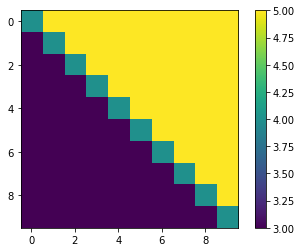

In [12]:
arr = dummy_pointer_grid(GRID_SIZE)
plt.imshow(arr)
plt.colorbar()

## Build the model graph

We now combine the pointer map, with the model template to come up with a single model graph, `g`.

This will represent the template in every grid cell. So, we have 100 grid cells resulting in 100 GR4J nodes, etc.

We build it up incrementally, **and add relevant tags as we go**. In this case, we add row and col tags

In [13]:
g = None

for row,col in list(zip(*np.where(arr))):
    g = templating.template_to_graph(g,template,row=row,col=col)


At this point, out graph contains 100 copies of the template, with row and col tags.

Now we need to link them up. Here we look back at the pointer map to see what direction a grid cell flows (and we just include E, SE, and S options!)

From the direction we can work out the destination grid cell and hence the destination node. We then add a link between the `LumpedConstituentRouting` nodes in each grid cell

In [14]:
for row,col in list(zip(*np.where(arr))):
    ptr = arr[row,col]
    if ptr==3:
        dest_row = row
        dest_col = col+1
    elif ptr==5:
        dest_row = row+1
        dest_col = col
    else:
        dest_row = row+1
        dest_col = col+1

    if dest_row >= GRID_SIZE:
        continue
    src_node = templating.match_nodes(g,_model='LumpedConstituentRouting',row=row,col=col)[0]
    dest_node = templating.match_nodes(g,_model='LumpedConstituentRouting',row=dest_row,col=dest_col)[0]
    
    g.add_edge(src_node,dest_node,src=['outflowLoad'],dest=['inflowLoad'])

Now we have the graph, we can convert it to an OpenWater model graph, which includes scheduling the models to run in different batches

In [15]:
model = templating.ModelGraph(g)

[19, 36, 51, 64, 56, 48, 40, 32, 24, 16, 9, 4, 1]


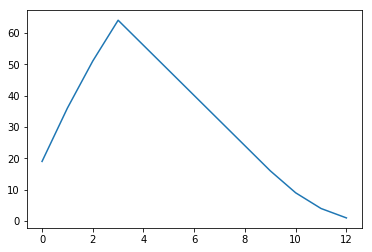

In [16]:
stage_lengths = [len(s) for s in model.order]
plt.plot(stage_lengths,label='sl')
print(stage_lengths)